# K4CV : 4-circle kappa diffractometer example

The kappa geometry replaces the traditional $\chi$-ring on a 4-circle
diffractometer with an alternative kappa stage that holds the phi stage. The kappa stage is tilted at angle $\alpha$ (typically 50 degrees) from the $\omega$ stage.

----

Note:  This example is available as a
[Jupyter notebook](https://jupyter.org/) from the *hklpy* source
code website: https://github.com/bluesky/hklpy/tree/main/docs/source/examples/notebooks

## Setup the *K4CV* diffractometer in *hklpy*

In _hkl_ *K4CV* geometry (https://people.debian.org/~picca/hkl/hkl.html#org723c5b9):

![K4CV geometry](resources/k4cv.png)

For this geometry there is a special parameter $\alpha$, the angle between the kappa rotation axis and the $\vec{y}$ direction.

axis  | moves    | rotation axis    | vector
---   | :---     | :---:            | :---
komega | sample   | $-\vec{y}$      | `[0 -1 0]`
kappa   | sample   | $\vec{x}$      | `[0 -0.6428 -0.7660]`
kphi   | sample   | $-\vec{y}$      | `[0 -1 0]`
tth   | detector | $-\vec{y}$       | `[0 -1 0]`


## Define _this_ diffractometer

Create a Python class that specifies the names of the 
real-space positioners.  We call it `KappaFourCircle` here but that
choice is arbitrary.  Pick any valid Python name not already in use.
The convention is to start Python class names with a capital letter
and use CamelCase to mark word starts.

The argument to the `KappaFourCircle` class tells which *hklpy* base
class will be used.  This sets the geometry.  (The class we show
here could be replaced entirely with `hkl.geometries.SimulatedK4CV`
but we choose to show here the complete steps to produce that class.)
The [*hklpy*
documentation](https://blueskyproject.io/hklpy/master/geometries.html)
provides a complete list of diffractometer geometries.


In *hklpy*, the reciprocal-space axes
are known as `pseudo` positioners while the real-space axes
are known as `real` positioners.  For the real positioners,
it is possible to use different names than the canonical names
used internally by the *hkl* library.  That is not covered here.

Note: The keyword argument `kind="hinted"` is an indication
that this signal may be plotted.

This `KappaFourCircle()` class example uses simulated motors.  See the drop-down
for an example how to use EPICS motors.

<details>
    <summary><tt>KappaFourCircle()</tt> class using EPICS motors</summary>


```python

from hkl import K4CV
from ophyd import EpicsMotor, PseudoSingle
from ophyd import Component as Cpt

class KappaFourCircle(K4CV):
    """
    Our kappa 4-circle.  Vertical scattering orientation.
    """
    # the reciprocal axes are called "pseudo" in hklpy
    h = Cpt(PseudoSingle, '', kind="hinted")
    k = Cpt(PseudoSingle, '', kind="hinted")
    l = Cpt(PseudoSingle, '', kind="hinted")

    # the motor axes are called "real" in hklpy
    komega = Cpt(EpicsMotor, "pv_prefix:m41", kind="hinted")
    kappa = Cpt(EpicsMotor, "pv_prefix:m22", kind="hinted")
    kphi = Cpt(EpicsMotor, "pv_prefix:m35", kind="hinted")
    tth = Cpt(EpicsMotor, "pv_prefix:m7", kind="hinted")
```

</details>

In [1]:
from hkl import K4CV, SimMixin
from ophyd import SoftPositioner
from ophyd import Component as Cpt

class KappaFourCircle(SimMixin, K4CV):
    """
    Our kappa 4-circle.  Vertical scattering orientation.
    """
    # the reciprocal axes are defined by SimMixin

    komega = Cpt(SoftPositioner, kind="hinted", init_pos=0)
    kappa = Cpt(SoftPositioner, kind="hinted", init_pos=0)
    kphi = Cpt(SoftPositioner, kind="hinted", init_pos=0)
    tth = Cpt(SoftPositioner, kind="hinted", init_pos=0)

Create the Python diffractometer object (`sixc`) using the `SixCircle()` class.  By convention, the `name` keyword is the same as the object name.

In [2]:
k4cv = KappaFourCircle("", name="k4cv")

## Add a sample with a crystal structure

In [3]:
from hkl import Lattice
from hkl import SI_LATTICE_PARAMETER

# add the sample to the calculation engine
a0 = SI_LATTICE_PARAMETER
k4cv.calc.new_sample(
    "silicon",
    lattice=Lattice(a=a0, b=a0, c=a0, alpha=90, beta=90, gamma=90)
    )

HklSample(name='silicon', lattice=LatticeTuple(a=5.431020511, b=5.431020511, c=5.431020511, alpha=90.0, beta=90.0, gamma=90.0), ux=Parameter(name='None (internally: ux)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uy=Parameter(name='None (internally: uy)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uz=Parameter(name='None (internally: uz)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), U=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), UB=array([[ 1.15690694e+00, -7.08401189e-17, -7.08401189e-17],
       [ 0.00000000e+00,  1.15690694e+00, -7.08401189e-17],
       [ 0.00000000e+00,  0.00000000e+00,  1.15690694e+00]]), reflections=[])

## Setup the UB orientation matrix using *hklpy*

Define the crystal's orientation on the diffractometer using 
the 2-reflection method described by [Busing & Levy, Acta Cryst 22 (1967) 457](https://www.psi.ch/sites/default/files/import/sinq/zebra/PracticalsEN/1967-Busing-Levy-3-4-circle-Acta22.pdf).

### Set the same X-ray wavelength for both reflections, by setting the diffractometer energy

In [4]:
from hkl import A_KEV
k4cv.energy.put(A_KEV / 1.54)  # (8.0509 keV)

### Find the first reflection and identify its Miller indices: (_hkl_)

In [5]:
r1 = k4cv.calc.sample.add_reflection(
    4, 0, 0,
    position=k4cv.calc.Position(
        tth=-69.0966,
        komega=55.4507,
        kappa=0,
        kphi=-90,
    )
)

### Find the second reflection

In [6]:
r2 = k4cv.calc.sample.add_reflection(
    0, 4, 0,
    position=k4cv.calc.Position(
        tth=-69.0966,
        komega=-1.5950,
        kappa=134.7568,
        kphi=123.3554
    )
)

### Compute the *UB* orientation matrix

The `add_reflection()` method uses the current wavelength at the time it is called.  (To add reflections at different wavelengths, change the wavelength _before_ calling `add_reflection()` each time.)  The `compute_UB()` method returns the computed **UB** matrix.  Ignore it here.

In [7]:
k4cv.calc.sample.compute_UB(r1, r2)

array([[ 2.01918352e-05, -7.20401174e-06, -1.15690694e+00],
       [ 0.00000000e+00, -1.15690694e+00,  7.20401174e-06],
       [-1.15690694e+00, -1.25733653e-10, -2.01918352e-05]])

## Report what we have setup

In [8]:
k4cv.pa()

===================== =================================================================================
term                  value                                                                            
===================== =================================================================================
diffractometer        k4cv                                                                             
geometry              K4CV                                                                             
class                 KappaFourCircle                                                                  
energy (keV)          8.05092                                                                          
wavelength (angstrom) 1.54000                                                                          
calc engine           hkl                                                                              
mode                  bissector                                 

## Check the orientation matrix

Perform checks with _forward_ (hkl to angle) and
_inverse_ (angle to hkl) computations to verify the diffractometer
will move to the same positions where the reflections were identified.

### Constrain one of the motors to a limited range

* keep `kphi` less than or equal to zero (allowing for small roundoff)

First, we apply constraints directly to the `calc`-level support.

In [9]:
k4cv.calc["kphi"].limits = (-180, 0.001)
k4cv.show_constraints()

====== ========= ========== ===== ====
axis   low_limit high_limit value fit 
====== ========= ========== ===== ====
komega -180.0    180.0      0.0   True
kappa  -180.0    180.0      0.0   True
kphi   -180.0    0.001      0.0   True
tth    -180.0    180.0      0.0   True
====== ========= ========== ===== ====



Next, we show how to use additional methods of `Diffractometer()` that support *undo* and *reset* features for applied constraints.  The support is based on a *stack* (a Python list).  A set of constraints is added (`apply_constraints()`) or removed (`undo_last_constraints()`) from the stack.  Or, the stack can be cleared (`reset_constraints()`).

method | what happens
:--- | :---
`apply_constraints()` | Add a set of constraints and use them
`undo_last_constraints()` | Remove the most-recent set of constraints and restore the previous one from the stack.
`reset_constraints()` | Set constraints back to initial settings.
`show_constraints()` | Print the current constraints in a table.

A set of constraints is a Python dictionary that uses the real positioner names (the motors) as the keys.  Only those constraints with changes need be added to the dictionary but it is permissable to describe all the real positioners.  Each value in the dictionary is a [`hkl.diffract.Constraint`](https://blueskyproject.io/hklpy/diffract.html#hkl.diffract.Constraint), where the values are specified in this order: `low_limit, high_limit, value, fit`.

`fit` | constraint
:--- | :---
`True` | Only accept solutions with positions between `low_limit` and `high_limit`.
`False` | Do not allow this positioner to be adjusted and fix its position to `value`.

Apply new constraints using the [`applyConstraints()`](https://blueskyproject.io/hklpy/diffract.html#hkl.diffract.Diffractometer.apply_constraints) method.  These *add* to the existing constraints, as shown in the table.

In [10]:
from hkl import Constraint
k4cv.apply_constraints(
    {
        "komega": Constraint(-0.001, 180, 0, True),
        "kappa": Constraint(-90, 90, 0, True),
    }
)
k4cv.show_constraints()

====== ========= ========== ===== ====
axis   low_limit high_limit value fit 
====== ========= ========== ===== ====
komega -0.001    180.0      0.0   True
kappa  -90.0     90.0       0.0   True
kphi   -180.0    0.001      0.0   True
tth    -180.0    180.0      0.0   True
====== ========= ========== ===== ====



Then remove (undo) those new additions.

In [11]:
k4cv.undo_last_constraints()
k4cv.show_constraints()

====== ========= ========== ===== ====
axis   low_limit high_limit value fit 
====== ========= ========== ===== ====
komega -180.0    180.0      0.0   True
kappa  -180.0    180.0      0.0   True
kphi   -180.0    0.001      0.0   True
tth    -180.0    180.0      0.0   True
====== ========= ========== ===== ====



### Use `bissector` mode

where `tth` = 2*`omega`

In [12]:
k4cv.engine.mode = "bissector"

### (400) reflection test

1. Check the `inverse` (angles -> (_hkl_)) computation.
1. Check the `forward` ((_hkl_) -> angles) computation.

### Check the inverse calculation: (400)

To calculate the (_hkl_) corresponding to a given set of motor angles,
call `k4cv.inverse((h, k, l))`.  Note the second set of parentheses needed by this function.

The values are specified, without names, in the order specified
by `k4cv.calc.physical_axis_names`.

In [13]:
print("axis names:", k4cv.calc.physical_axis_names)

axis names: ['komega', 'kappa', 'kphi', 'tth']


Now, proceed with the inverse calculation.

In [14]:
sol = k4cv.inverse((55.4507, 0, -90, -69.0966))
print(f"(4 0 0) ? {sol.h:.2f} {sol.k:.2f} {sol.l:.2f}")

(4 0 0) ? 4.00 -0.00 -0.00


### Check the forward calculation: (400)

Compute the angles necessary to position the diffractometer
for the given reflection.

Note that for the forward computation, more than one set of angles may be used to reach the same crystal reflection.  This test will report the *default* selection.  The *default* selection (which may be changed through methods described in the `hkl.calc` module) is the first solution.

function | returns
--- | ---
`k4cv.forward()` | The *default* solution
`k4cv.calc.forward()` | List of all allowed solutions.

In [15]:
sol = k4cv.forward((4, 0, 0))
print(
    "(400) :", 
    f"tth={sol.tth:.4f}", 
    f"komega={sol.komega:.4f}", 
    f"kappa={sol.kappa:.4f}", 
    f"kphi={sol.kphi:.4f}"
    )

(400) : tth=-69.0982 komega=55.4509 kappa=0.0000 kphi=-90.0010


### (040) reflection test

Repeat the `inverse` and `forward` calculations for the
second orientation reflection.

### Check the inverse calculation: (040)

In [16]:
sol = k4cv.inverse((-1.5950, 134.7568, 123.3554, -69.0966))
print(f"(0 4 0) ? {sol.h:.2f} {sol.k:.2f} {sol.l:.2f}")

(0 4 0) ? -0.00 4.00 0.00


### Check the forward calculation: (040)

In [17]:
sol = k4cv.forward((0, 4, 0))
print(
    "(040) :", 
    f"tth={sol.tth:.4f}", 
    f"komega={sol.komega:.4f}", 
    f"kappa={sol.kappa:.4f}", 
    f"kphi={sol.kphi:.4f}"
    )

(040) : tth=-69.0982 komega=-1.5937 kappa=134.7551 kphi=-57.0465


## Scan in reciprocal space using Bluesky

To scan with Bluesky, we need more setup.

In [18]:
%matplotlib inline

from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky.magics import BlueskyMagics
import bluesky.plans as bp
import bluesky.plan_stubs as bps
import databroker
from IPython import get_ipython
import matplotlib.pyplot as plt

plt.ion()

bec = BestEffortCallback()
db = databroker.temp().v1
sd = SupplementalData()

get_ipython().register_magics(BlueskyMagics)

RE = RunEngine({})
RE.md = {}
RE.preprocessors.append(sd)
RE.subscribe(db.insert)
RE.subscribe(bec)

1

### (_h00_) scan near (400)

In this example, we have no detector.  Still, we add the diffractometer
object in the detector list so that the _hkl_ and motor positions will appear
as columns in the table.



Transient Scan ID: 1     Time: 2022-06-13 00:01:09
Persistent Unique Scan ID: 'da7e51f5-0c0c-4556-a06c-90d0dc58e7a8'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_h |     k4cv_k |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 00:01:09.5 |      3.900 |      0.000 |      0.000 |      56.431 |      0.000 |    -90.001 |    -67.137 |
|         2 | 00:01:10.0 |      3.950 |     -0.000 |      0.000 |      55.943 |     -0.000 |    -90.001 |    -68.115 |
|         3 | 00:01:10.5 |      4.000 |     -0.000 |     -0.000 |      55.451 |      0.000 |    -90.001 |    -69.098 |
|         4 | 00:01:11.1 |      4.050 |     -0.000 |      0.000 |      54.956 |     -0.000 |    -90.001 |    -70.087 |
|         5 | 00:01:11.6 |

('da7e51f5-0c0c-4556-a06c-90d0dc58e7a8',)

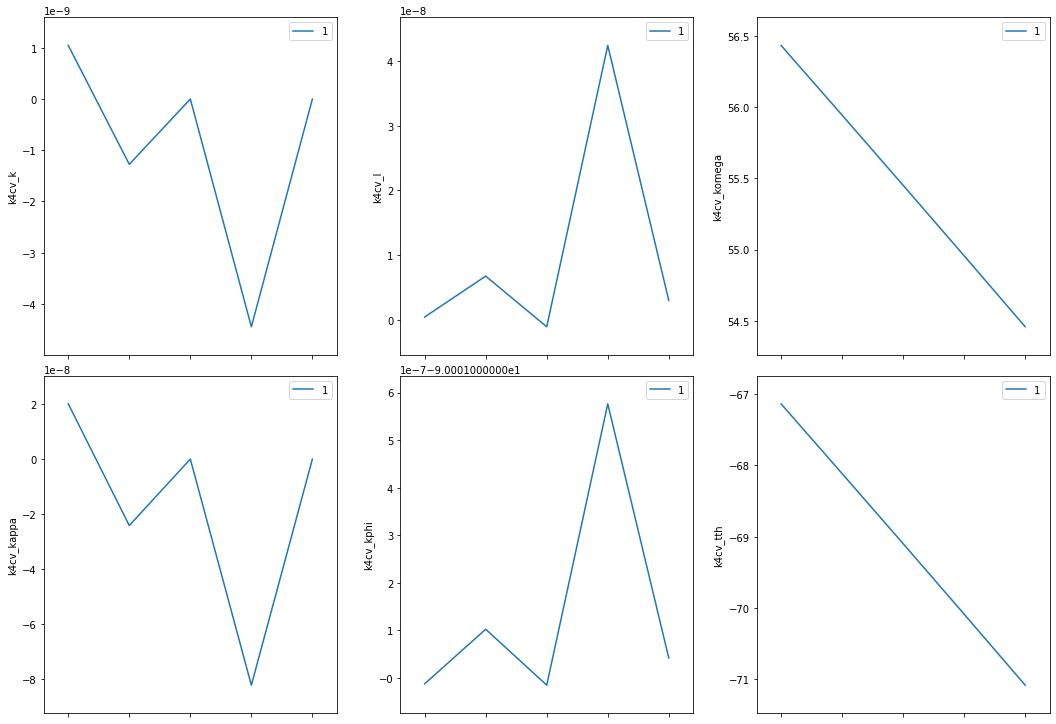

In [19]:
RE(bp.scan([k4cv], k4cv.h, 3.9, 4.1, 5))

### (_hk0_) scan from (400) to (040)

Scan between the two orientation reflections.  Need to
keep $\varphi\ge0$ to avoid big jumps during the scan.



Transient Scan ID: 2     Time: 2022-06-13 00:01:13
Persistent Unique Scan ID: '3c5ec733-bd55-42ad-ab0b-2b6ee6445eeb'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_h |     k4cv_k |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 00:01:13.2 |      4.000 |      0.000 |      0.000 |    -124.550 |     -0.000 |     90.000 |    -69.098 |
|         2 | 00:01:13.6 |      3.556 |      0.444 |      0.000 |    -117.539 |     -9.305 |     92.995 |    -61.064 |
|         3 | 00:01:13.9 |      3.111 |      0.889 |      0.000 |    -110.558 |    -20.863 |     96.749 |    -54.611 |
|         4 | 00:01:14.3 |      2.667 |      1.333 |     -0.000 |    -103.581 |    -34.906 |    101.425 |    -50.010 |
|         5 | 00:01:14.6 |

('3c5ec733-bd55-42ad-ab0b-2b6ee6445eeb',)

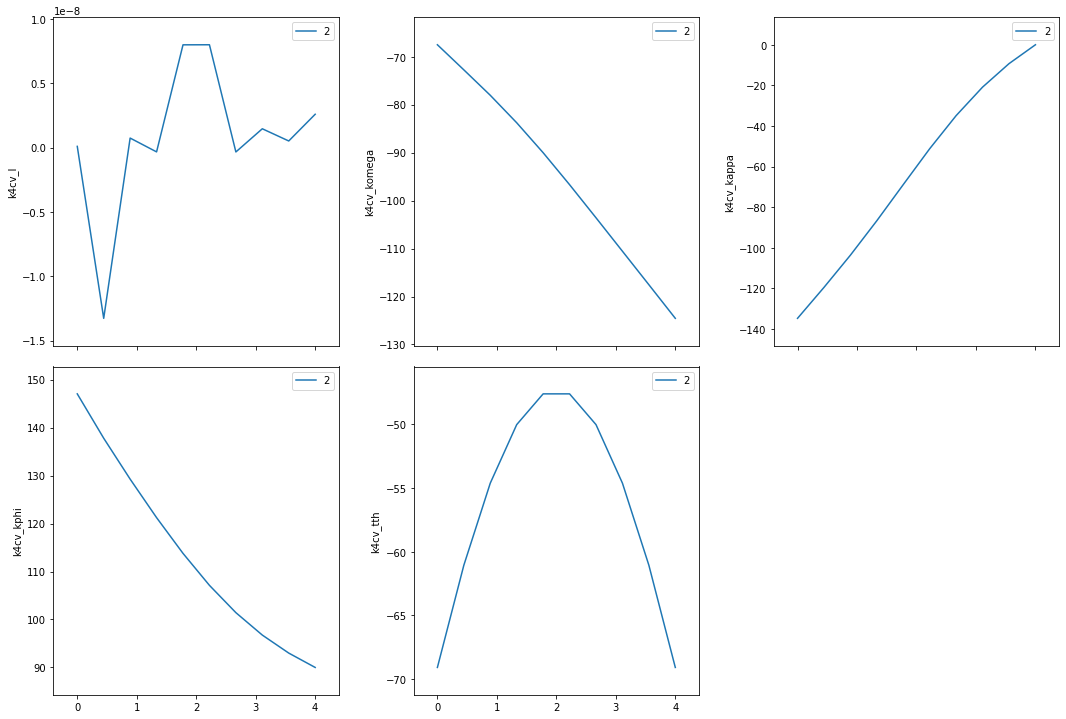

In [20]:
k4cv.calc.engine.mode = "constant_phi"
k4cv.apply_constraints(
    {
        "kphi": Constraint(0, 180, 0, True),
    }
)

RE(bp.scan([k4cv], k4cv.h, 4, 0, k4cv.k, 0, 4, 10))

### (_0k0_) scan near (040)



Transient Scan ID: 3     Time: 2022-06-13 00:01:17
Persistent Unique Scan ID: '32156dc6-eafd-43db-8790-8329e5aabd41'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_k |     k4cv_h |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 00:01:17.6 |      3.900 |     -0.000 |      0.000 |     -66.523 |   -134.756 |    147.045 |    -67.137 |
|         2 | 00:01:18.1 |      3.950 |     -0.000 |     -0.000 |     -67.012 |   -134.756 |    147.045 |    -68.115 |
|         3 | 00:01:18.6 |      4.000 |     -0.000 |      0.000 |     -67.504 |   -134.756 |    147.045 |    -69.098 |
|         4 | 00:01:19.1 |      4.050 |     -0.000 |      0.000 |     -67.998 |   -134.756 |    147.045 |    -70.087 |
|         5 | 00:01:19.6 |

('32156dc6-eafd-43db-8790-8329e5aabd41',)

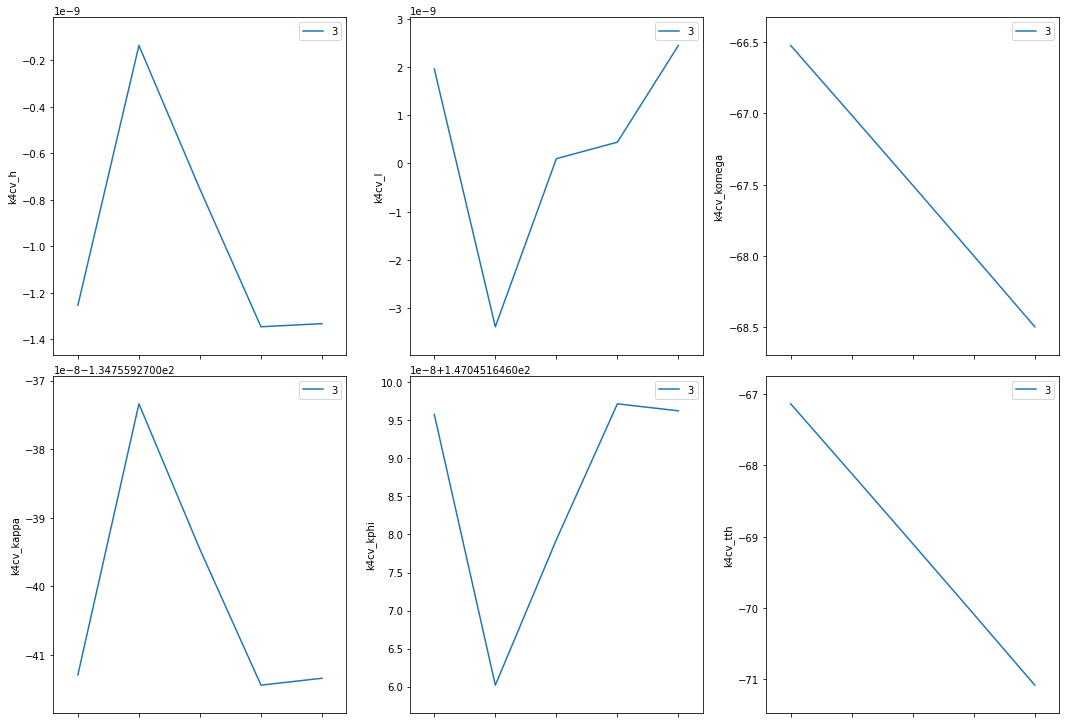

In [21]:
RE(bp.scan([k4cv], k4cv.k, 3.9, 4.1, 5))

### (_hk0_) scan near (440)



Transient Scan ID: 4     Time: 2022-06-13 00:01:21
Persistent Unique Scan ID: '2205ffb9-a999-4e3a-92f9-d0e200a204c1'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_h |     k4cv_k |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 00:01:21.4 |      3.900 |      4.100 |      0.000 |    -122.253 |    -61.940 |    111.095 |   -106.695 |
|         2 | 00:01:21.7 |      3.950 |      4.050 |      0.000 |    -122.614 |    -60.940 |    110.715 |   -106.659 |
|         3 | 00:01:22.1 |      4.000 |      4.000 |     -0.000 |    -122.985 |    -59.941 |    110.339 |   -106.647 |
|         4 | 00:01:22.4 |      4.050 |      3.950 |      0.000 |    -123.365 |    -58.946 |    109.965 |   -106.659 |
|         5 | 00:01:22.8 |

('2205ffb9-a999-4e3a-92f9-d0e200a204c1',)

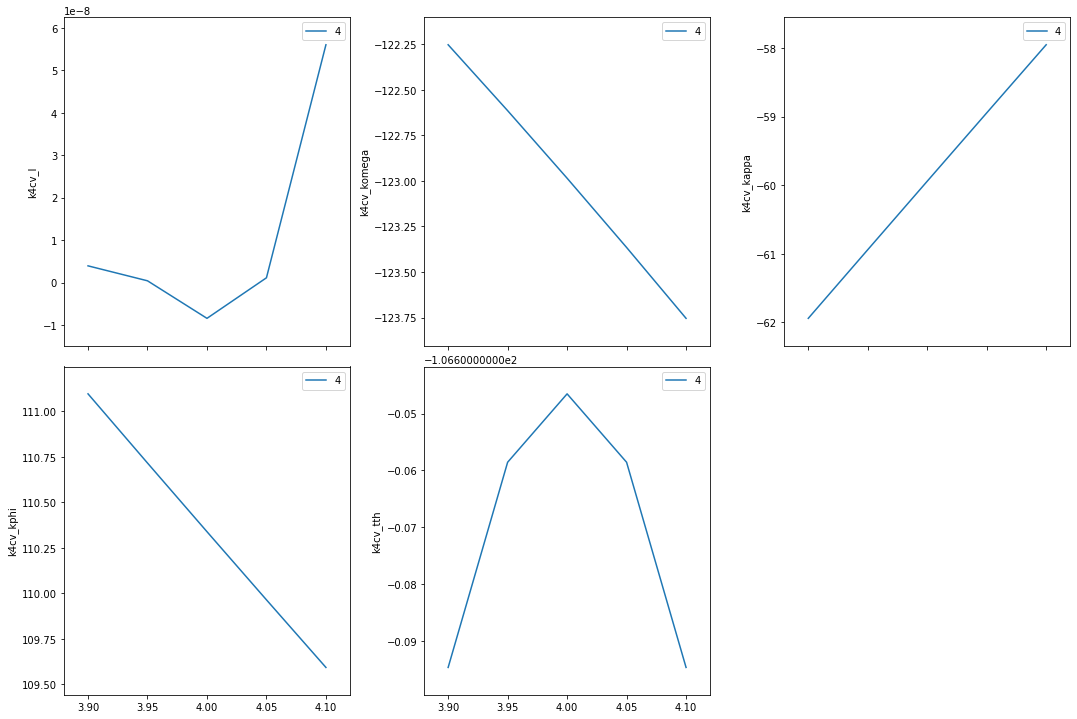

In [22]:
RE(bp.scan([k4cv], k4cv.h, 3.9, 4.1, k4cv.k, 4.1, 3.9, 5))

Move to the (_440_) reflection.

In [23]:
k4cv.move((4,4,0))
print(f"{k4cv.position = }")

k4cv.position = KappaFourCirclePseudoPos(h=4.000000003222206, k=3.9999999888536113, l=-1.88325082367423e-08)


Repeat the same scan about the (_440_) but use _relative_ positions.



Transient Scan ID: 5     Time: 2022-06-13 00:01:24
Persistent Unique Scan ID: '3fdf583b-5c80-4905-b579-ac5e2c9628a2'
New stream: 'primary'
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|   seq_num |       time |     k4cv_h |     k4cv_k |     k4cv_l | k4cv_komega | k4cv_kappa |  k4cv_kphi |   k4cv_tth |
+-----------+------------+------------+------------+------------+-------------+------------+------------+------------+
|         1 | 00:01:24.2 |      3.900 |      3.900 |      0.000 |    -121.103 |    -59.941 |    110.339 |   -102.882 |
|         2 | 00:01:24.5 |      3.950 |      3.950 |     -0.000 |    -122.034 |    -59.941 |    110.339 |   -104.744 |
|         3 | 00:01:24.9 |      4.000 |      4.000 |     -0.000 |    -122.985 |    -59.941 |    110.339 |   -106.647 |
|         4 | 00:01:25.3 |      4.050 |      4.050 |     -0.000 |    -123.958 |    -59.941 |    110.339 |   -108.592 |
|         5 | 00:01:25.7 |

('3fdf583b-5c80-4905-b579-ac5e2c9628a2',)

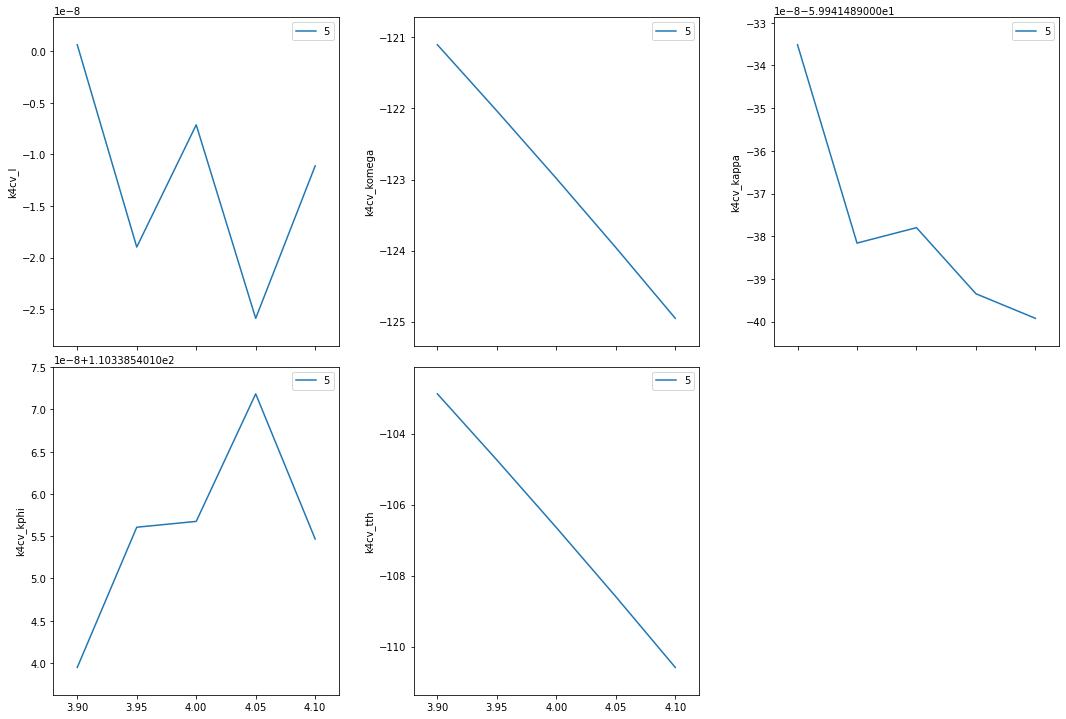

In [24]:
RE(bp.rel_scan([k4cv], k4cv.h, -0.1, 0.1, k4cv.k, -0.1, 0.1, 5))